# Исследование рынка игр

В нашем распоряжении исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Наша задача - выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

В ходе исследования также проверим две гипотезы:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшенигры) и Sports (англ. «спортивные соревнования») разные.


## Изучение данных из файла

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st

In [2]:
df = pd.read_csv('/datasets/games.csv')
display(df.head(10))
df.info()


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Вывод

В каждой строке таблицы — данные об игре (название, платформа, год выпуска, продажи, оценки).

Предварительно можно утверждать, что, данных достаточно для решения стоящей перед нами задачи. Но встречаются пропуски в данных, а в названиях колонок — расхождения с хорошим стилем.

Чтобы двигаться дальше, нужно устранить проблемы в данных.

## Предобработка данных

Приведём все заголовки столбцов к нижнему регистру.

In [3]:
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Посмотрим и посчитаем количество пропусков.

In [4]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Пропуски в годах выпуска игр по платформам.

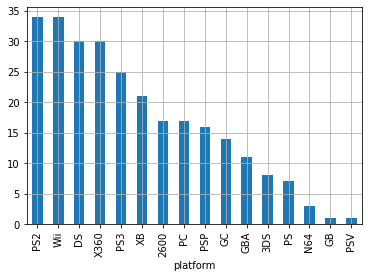

In [5]:
df.query('year_of_release.isna()').groupby('platform')['name'].agg('count').sort_values(ascending=False).plot(y='count', kind='bar', grid=True)
plt.show()

Заметно выделяющихся позиций нет. Большее количество пропусков в наиболее популярных и известных платформах. 
Вероятно, здесь были ошибки ввода данных.

У части игр отсутствует дата выпуска по одной из платформ, хотя на других дата стоит. Сгруппируем по играм и найдём средний год выпуска по имеющимся платформам для заполнения пропусков по отдельным платформам.

In [6]:
name_transformed = df.groupby('name')['year_of_release'].transform('mean')
df['year_of_release'] = df['year_of_release'].fillna(name_transformed)

В некоторых играх, как правило спортивных, в самом названии есть год. Возьмём этот год для замены.

In [7]:
def func(row):
    if pd.isna(row['year_of_release']):
        num = ''
        for c in row['name']:
            if c.isdigit():
                num += c
        return num
    return row['year_of_release']


df['year_of_release'] = df.apply(func, axis=1)

С течением времени платформы развиваются и сменяют друг друга. Оставшиеся пропуски заменим средним значением по данным, сгруппированным по платформам.

In [8]:
df['year_of_release'] = pd.to_numeric(df['year_of_release'], errors='coerce')
platform_transformed = df.groupby('platform')['year_of_release'].transform('mean')
df['year_of_release'] = df['year_of_release'].fillna(platform_transformed)
df['year_of_release'] = df['year_of_release'].astype('int')
df['year_of_release'].value_counts().tail(10)

1984    14
2       10
1980     9
3        4
99       2
5        1
500      1
20       1
4        1
64       1
Name: year_of_release, dtype: int64

Возникли странные значения из-за цифр, встречающихся в названии и никак не соотносящиеся с годом (последствия обработки функцией). Эти данные отфильтруем, тем более они составляют очень малую часть.

Между 1969 и 1980 не выпущено ни одной игры. Также с 1980 видим рост количества игр. Скорее всего это ошибка ввода, но чтобы не искажать данные отфильтруем эти значения. 

In [9]:
display(df['year_of_release'].value_counts().tail())
df = df.query('year_of_release > 1969')
display(df.shape)
df['year_of_release'].value_counts().tail()

5      1
500    1
20     1
4      1
64     1
Name: year_of_release, dtype: int64

(16679, 11)

1987    16
1988    15
1985    14
1984    14
1980     9
Name: year_of_release, dtype: int64

Отфильтровано 36 игр.

Посмотрим на значения столбца `user_score`.

In [10]:
df['user_score'].value_counts()

tbd    2422
7.8     324
8       289
8.2     281
8.3     254
       ... 
1.3       2
2.3       2
1         2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

Самое частое значение - tbd (от англ. to be determined - будет определено). На момент выгрузки данные по этим играм ещё не появились. Так как их нет, заменим это значение на NaN (если заменить на 0 - это будет расценено как низкий рейтинг и исказит смысл).

In [11]:
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

In [12]:
df['rating'] = df['rating'].fillna('Без рейтинга')    

Посчитаем и добавим в таблицу суммарные продажи по играм по всем регионам.

In [13]:
df['sum_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df = df[['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'sum_sales', 'critic_score', 'user_score', 'rating']]
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,sum_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,82.54,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,40.24,NaN,NaN,Без рейтинга
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,35.52,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,32.77,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,31.38,NaN,NaN,Без рейтинга


### Вывод

В данных было достаточно большое количество пропусков. Пропуски не носят системный характер. Где было возможно их заполнили. 

## Исследовательский анализ данных

### Количество игр, выпускаемое по годам

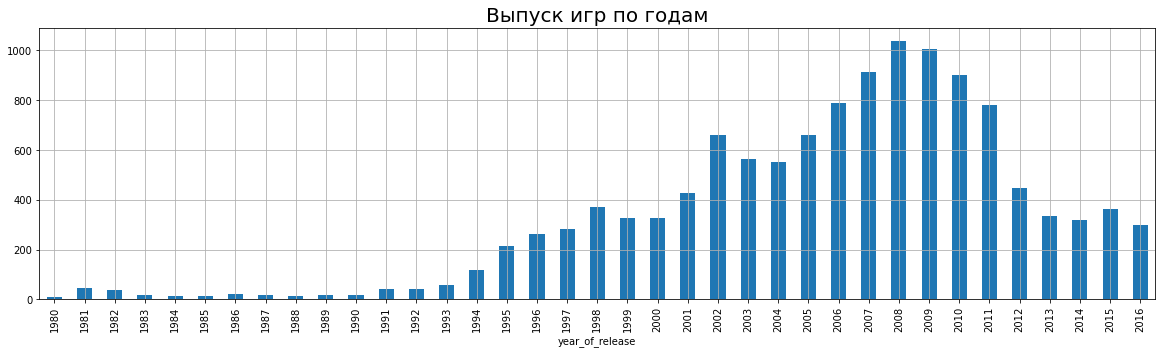

In [14]:
df.groupby('year_of_release')['name'].agg('nunique').plot(kind='bar', figsize=(20,5), grid=True)
plt.title('Выпуск игр по годам', fontsize=20)
plt.show()

С 1980 по 1990 года выпускается максимум по 2-3 десятка игр. С 1991 года наблюдается ежегодное увеличение. С 2002 по 2011 годы пик выпуска игр. С 2012 года количество игр варьируется в районе отметки в 600 игр ежегодно. Активный рост и развитие индустрии идёт с 2002 года, период до 2002 года можно считать становлением и не учитывать его в дальнейшем.

### Cуммарные продажи по платформам

In [15]:
df.groupby('platform')['sum_sales'].agg('sum').sort_values(ascending=False)

platform
PS2     1254.91
X360     970.67
PS3      937.99
Wii      906.88
DS       806.02
PS       729.40
GBA      317.85
PS4      314.14
PSP      294.01
PC       259.33
3DS      258.93
XB       257.40
GB       255.46
NES      251.05
N64      218.48
SNES     200.04
GC       198.93
XOne     159.32
2600      89.01
WiiU      82.19
PSV       53.81
SAT       33.59
GEN       30.77
DC        15.95
SCD        1.86
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: sum_sales, dtype: float64

Шесть первых платформ выделяются по продажам на общем фоне.

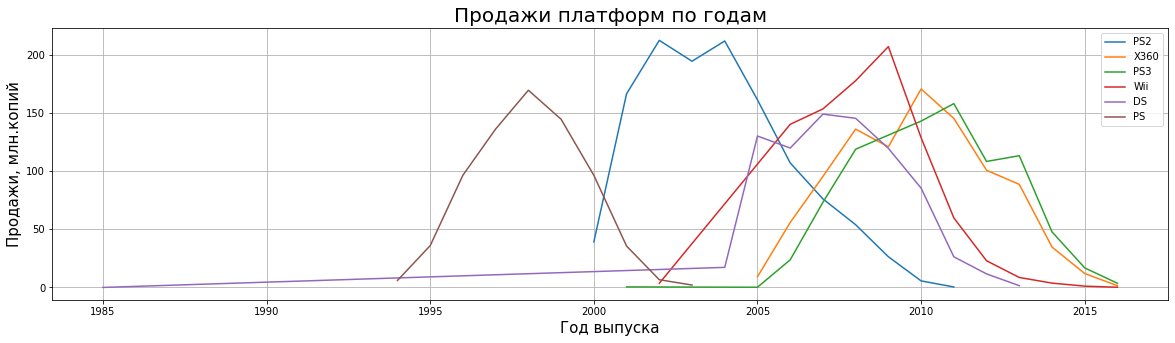

In [16]:
for x in ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']:
    df[df['platform'] == x].groupby('year_of_release')['sum_sales'].agg('sum').plot(label=x, figsize=(20,5), grid=True)
plt.legend()
plt.title('Продажи платформ по годам', fontsize=20)
plt.xlabel('Год выпуска', fontsize=15)
plt.ylabel('Продажи, млн.копий', fontsize=15)
plt.show()

К 2016 году закончился выпуск игр самых успешных платформ. На примере этого графика можно наблюдать сроки их развития и использования. 

PS3 и X360 появляются в 2005, выходят на пик к 2010-2011 годам, к 2016 году продажи прекращаются. Итого 11 лет.

Wii появляется в 2002, в 2015 выпуск игр прекращается; DS используется с 2004 по 2013.  

Характерные черты: пика продаж новая платформа достигает к 4-5 году; срок "жизни" платформы, в среднем, длится 11 лет.

### Выбор актуального периода

Судя по графику продажи игр, возможны как и резкий рост, так и сильное падение числа выпускаемых игр.  Поэтому за актуальный для дальнейших исследований период возьмём данные за 2015-2016 гг.

In [17]:
df_actual = df.query('year_of_release > 2014')

Посмотрим на платформы в актуальном периоде.

In [18]:
df_actual.groupby('platform')['sum_sales'].agg('sum').sort_values(ascending=False)

platform
PS4     188.15
XOne     86.29
3DS      42.92
WiiU     20.95
PS3      20.42
PC       13.77
X360     13.48
PSV      10.50
Wii       1.32
PSP       0.12
Name: sum_sales, dtype: float64

PS4 - лидер продаж - 188 млн. копий. Затем XOne - 86 млн. копий.

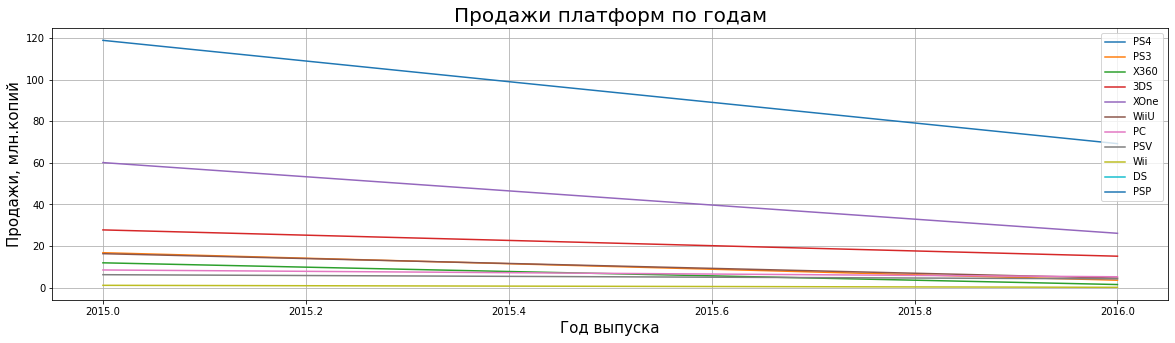

In [19]:
for x in ['PS4', 'PS3', 'X360', '3DS', 'XOne', 'WiiU', 'PC', 'PSV', 'Wii', 'DS', 'PSP']:
    df_actual[df_actual['platform'] == x].groupby('year_of_release')['sum_sales'].agg('sum').plot(label=x, figsize=(20,5), grid=True)
plt.legend()
plt.title('Продажи платформ по годам', fontsize=20)
plt.xlabel('Год выпуска', fontsize=15)
plt.ylabel('Продажи, млн.копий', fontsize=15)
plt.show()

Основная тенденция такова, что продажи всех платформ снижаются к 2016 году. Пока сложно выделить потенциально прибыльные. Посмотрим на более длительном отрезке.

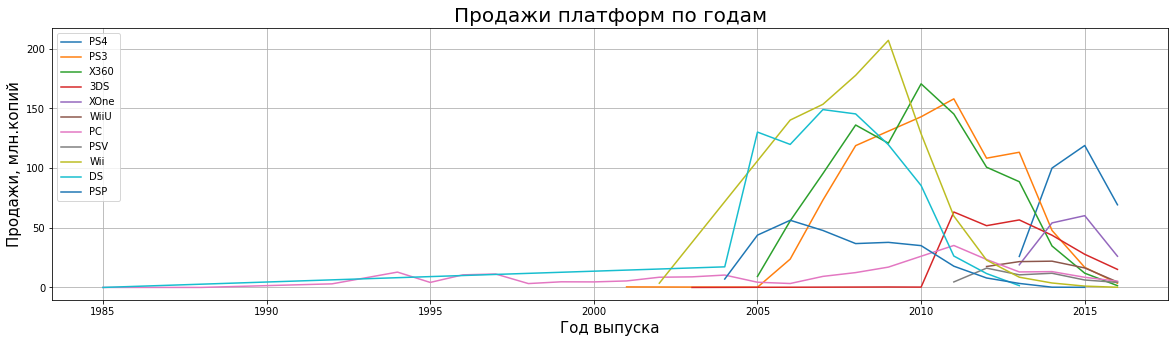

In [20]:
for x in ['PS4', 'PS3', 'X360', '3DS', 'XOne', 'WiiU', 'PC', 'PSV', 'Wii', 'DS', 'PSP']:
    df[df['platform'] == x].groupby('year_of_release')['sum_sales'].agg('sum').plot(label=x, figsize=(20,5), grid=True)
plt.legend()
plt.title('Продажи платформ по годам', fontsize=20)
plt.xlabel('Год выпуска', fontsize=15)
plt.ylabel('Продажи, млн.копий', fontsize=15)
plt.show()

К потенциально прибыльным можно отнести PS4 и XOne. Они появились в 2013 году и их "жизненный" цикл только начинается.  

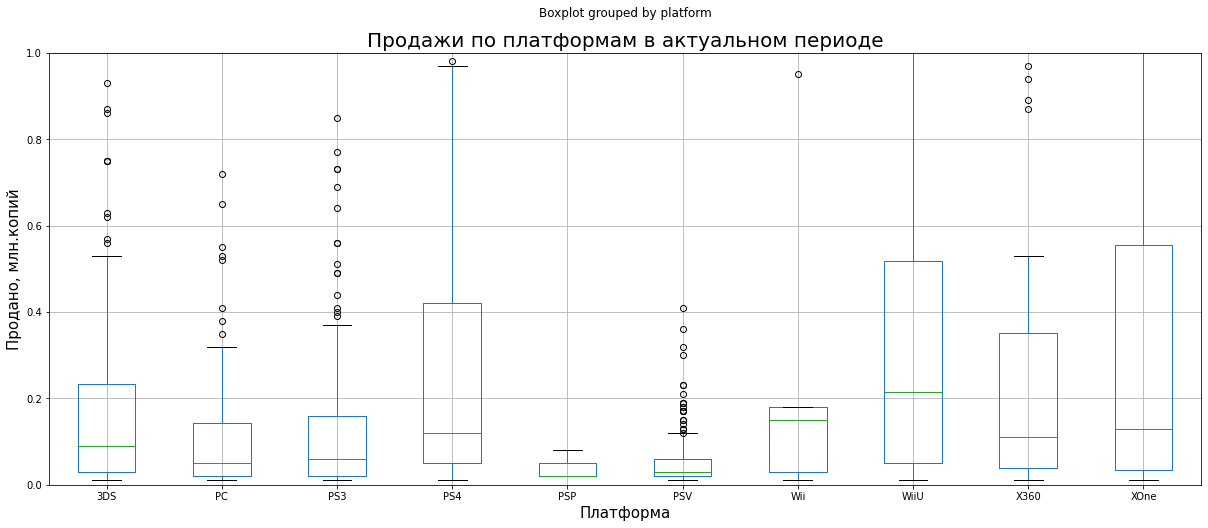

In [21]:
df_actual.boxplot(column='sum_sales',by='platform', figsize=(20,8))
plt.ylim(0,1)
plt.title('Продажи по платформам в актуальном периоде', fontsize=20)
plt.xlabel('Платформа', fontsize=15)
plt.ylabel('Продано, млн.копий', fontsize=15)
plt.show()

Если игра была выпущена на одной из таких популярных платформ, как PS4, WiiU, X360, XOne, у неё выше шансы разойтись большим тиражом. Самое высокое медианное значение у WiiU - чуть более 0,2 млн. копий.

### Взаимосвязь между отзывами пользователей и критиков с продажами

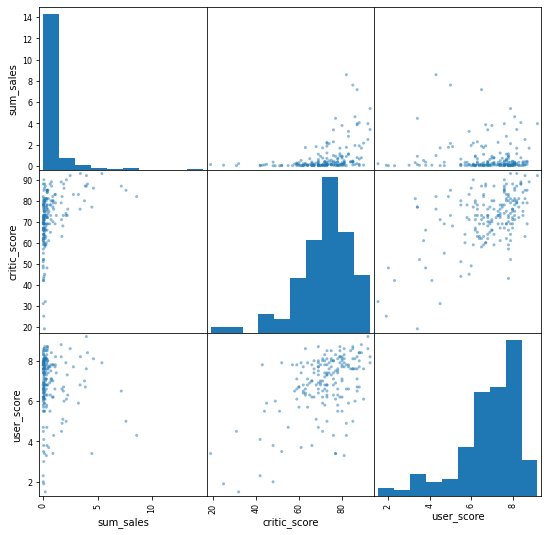

,sum_sales,critic_score,user_score
sum_sales,1.000000,0.392849,-0.059738
critic_score,0.392849,1.000000,0.533330
user_score,-0.059738,0.533330,1.000000


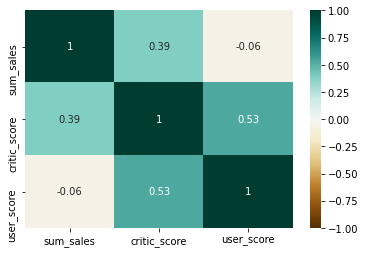

In [22]:
ps4 = df_actual.query('platform == "PS4"')[['sum_sales', 'critic_score', 'user_score']]
pd.plotting.scatter_matrix(ps4, figsize=(9,9))
plt.show()
display(ps4.corr())
sns.heatmap(ps4.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.show()

Оценки пользователей никак не взаимосвязаны с продажами; есть некая связь оценок критиков, но она очень слаба, чтобы утверждать об этом уверенно. 

Сравним эти выводы с данными по другим платформам.

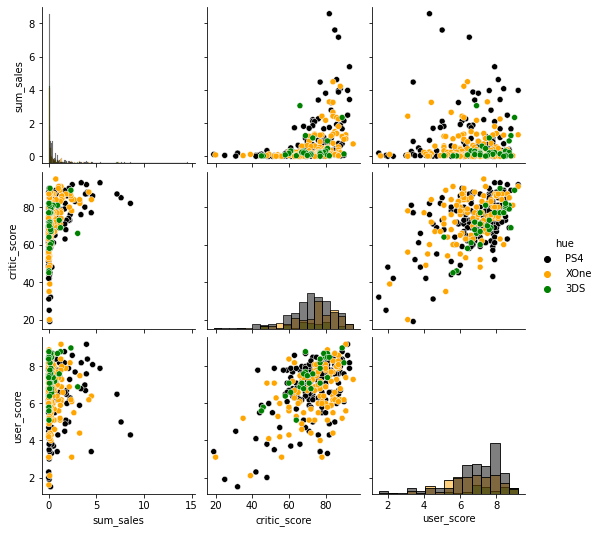

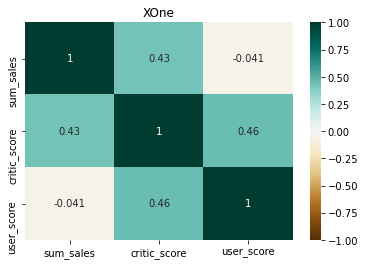

,sum_sales,critic_score,user_score
sum_sales,1.000000,0.430889,-0.041467
critic_score,0.430889,1.000000,0.459443
user_score,-0.041467,0.459443,1.000000


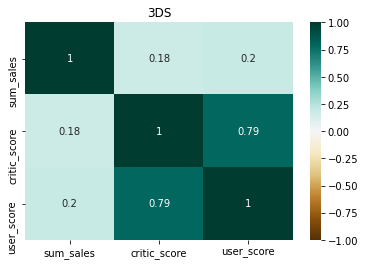

,sum_sales,critic_score,user_score
sum_sales,1.000000,0.177575,0.198796
critic_score,0.177575,1.000000,0.791853
user_score,0.198796,0.791853,1.000000


In [23]:
xone = df_actual.query('platform == "XOne"')[['sum_sales', 'critic_score', 'user_score']]
ds = df_actual.query('platform == "3DS"')[['sum_sales', 'critic_score', 'user_score']]
sns.pairplot(pd.concat([ps4.assign(hue='PS4'), 
                        xone.assign(hue='XOne'),
                        ds.assign(hue='3DS')]), 
             hue='hue', 
             diag_kind='hist', 
             palette=['k', 'orange', 'green'])
plt.show()
sns.heatmap(xone.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title('XOne')
plt.show()
display(xone.corr())
sns.heatmap(ds.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title('3DS')
plt.show()
display(ds.corr())

Диаграммы рассеяния и коэффициенты корреляции по платформе XOne показывает чуть большую взаимосвязь, на платформе 3DS связь не найдена.

### Распределение игр по жанрам

In [24]:
df_actual.pivot_table(index='genre', values='name', aggfunc='count').sort_values(by='name', ascending=False)

,name
genre,
Action,431
Role-Playing,132
Adventure,110
Sports,107
Shooter,81
Misc,71
Racing,42
Fighting,37
Simulation,33


Больше всего игр выпущено в жанре Action - 431 игра, меньше всего - Puzzle - 7 шт.

In [25]:
df_actual.pivot_table(index='genre', values='sum_sales', aggfunc='median').sort_values(by='sum_sales', ascending=False)

,sum_sales
genre,
Shooter,0.380
Sports,0.120
Role-Playing,0.115
Platform,0.100
Simulation,0.100
Fighting,0.090
Action,0.060
Misc,0.060
Racing,0.055


В среднем, наиболее продаваемые игры принадлежат к жанру Shooter - 0,38 млн копий, затем Sports - 0,12 млн копий, Role-Playing - 0,115 млн копий. Как правило, в этих жанрах присутствует мультиплеерный режим игры, что является дополнительной привлекательной характеристикой для пользователей.

Также выделяются и жанры с низкими продажами: Strategy - 0,05 млн копий, Adventure - 0.03 млн копий (по количеству выпускаемых игр жанр входит в ТОП-3), Puzzle - 0,03 млн копий. 

### Вывод

С 1991 года наблюдается ежегодное увеличение выпускаемых игр. В 2002 был резкий рост, с таким же резким падением в 2012 году. Пик выпуска новых игр пришёлся на период 2008-2009 гг.  С 2012 года количество игр варьируется в районе отметки в 600 игр ежегодно.

Можно выделить наиболее популярные и успешные платформы с точки зрения количества проданных копий игр по итогу на 2016 год: PS2 - 1254.91; X360 - 970.67; PS3 - 937.99; Wii - 906.88; DS - 806.02; PS - 729.40. 

Срок "жизни" платформы, в среднем, длится 10-11 лет.

К потенциально прибыльным можно отнести PS4 и XOne. Они появились в 2013 году и их "жизненный" цикл только начинается.

Оценки пользователей никак не влияют на высокие продажи игры. Игры, которые высоко оценены критиками, часто хорошо продаются, но так бывает не всегда.

За последние два года больше всего игр выпущено в жанре Action - 431 игра, меньше всего - Puzzle - 7 шт. При этом лидеры по среднему количеству проданных копий такие жанры: Shooter - 0,38 млн копий, затем Sports - 0,12 млн копий, Role-Playing - 0,115 млн копий.

### Портрет пользователя каждого региона

#### Популярные платформы по регионам.

,na_sales
platform,
PS4,63.86
XOne,50.30
3DS,10.31
WiiU,8.86
X360,8.05


,eu_sales
platform,
PS4,83.54
XOne,28.10
PC,9.10
3DS,7.39
PS3,7.30


,jp_sales
platform,
3DS,23.55
PS4,12.05
PSV,8.41
PS3,4.97
WiiU,4.12


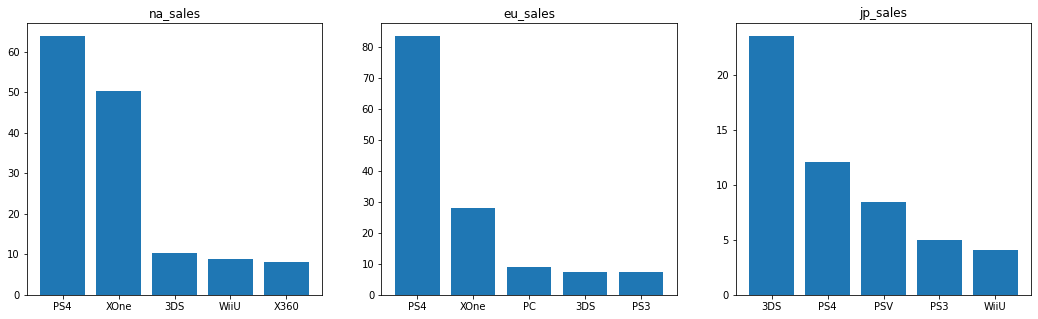

In [26]:
for x in ['na_sales', 'eu_sales', 'jp_sales']:
    x = df_actual.pivot_table(index='platform', values=x, aggfunc='sum').sort_values(by=x, ascending=False).head()
    display(x)

na_sales = df_actual.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head()    
eu_sales = df_actual.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head()    
jp_sales = df_actual.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head()    
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.bar(na_sales.index, na_sales['na_sales'])
plt.title('na_sales')
plt.subplot(1, 3, 2)
plt.bar(eu_sales.index, eu_sales['eu_sales'])
plt.title('eu_sales')
plt.subplot(1, 3, 3)
plt.bar(jp_sales.index, jp_sales['jp_sales'])
plt.title('jp_sales')
plt.show()    

В Северной Америке лидирующее положение занимают две платформы: PS4 - 64 млн проданных копий и XOne - 50 млн копий.

В Европе лидеры те же: PS4 и XOne (83 млн копий и 28 млн копий). Среди игр для приставок на третьем месте игры для ПК. В других регионах такого нет.

В Японии популярны портативные консоли: 3DS на первом месте - 23 млн копий, PSV на третьем месте - 8 млн копий.

#### Популярные жанры по регионам.

,na_sales
genre,
Shooter,48.18
Action,33.68
Sports,26.31
Role-Playing,19.82
Misc,5.58


,eu_sales
genre,
Shooter,40.28
Action,34.82
Sports,27.82
Role-Playing,17.21
Racing,6.52


,jp_sales
genre,
Action,23.05
Role-Playing,13.41
Shooter,3.79
Misc,3.19
Adventure,2.22


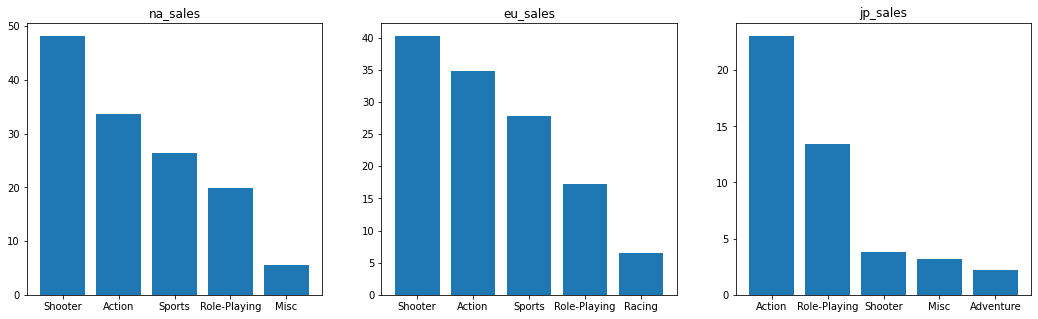

In [27]:
for x in ['na_sales', 'eu_sales', 'jp_sales']:
    x = df_actual.pivot_table(index='genre', values=x, aggfunc='sum').sort_values(by=x, ascending=False).head()
    display(x)

na_sales = df_actual.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head()    
eu_sales = df_actual.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head()    
jp_sales = df_actual.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head()    
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.bar(na_sales.index, na_sales['na_sales'])
plt.title('na_sales')
plt.subplot(1, 3, 2)
plt.bar(eu_sales.index, eu_sales['eu_sales'])
plt.title('eu_sales')
plt.subplot(1, 3, 3)
plt.bar(jp_sales.index, jp_sales['jp_sales'])
plt.title('jp_sales')
plt.show()

В Северной Америке и Европе практически одинаковые жанровые предпочтения: Shooter, Action, Sports, Role-Playing. Единственное различие на пятом месте в Северной Америке Misc, в Европе - Racing.

В Японии популярные жанры немного отличаются набором и соотношением. Сильно популярны Action и Role-Playing; Shooter, Misc, Adventure заметно уступают в популярности.

#### Влияние рейтинга ESRB на продажи в отдельном регионе.

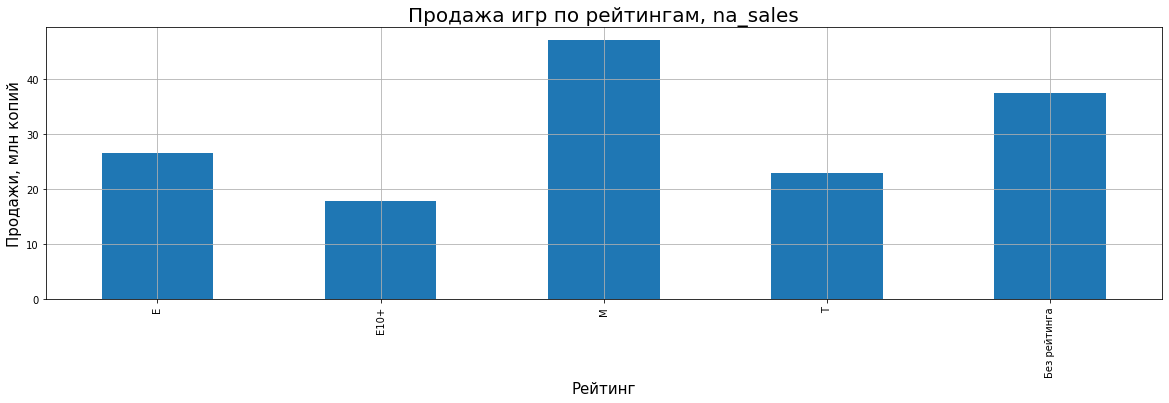

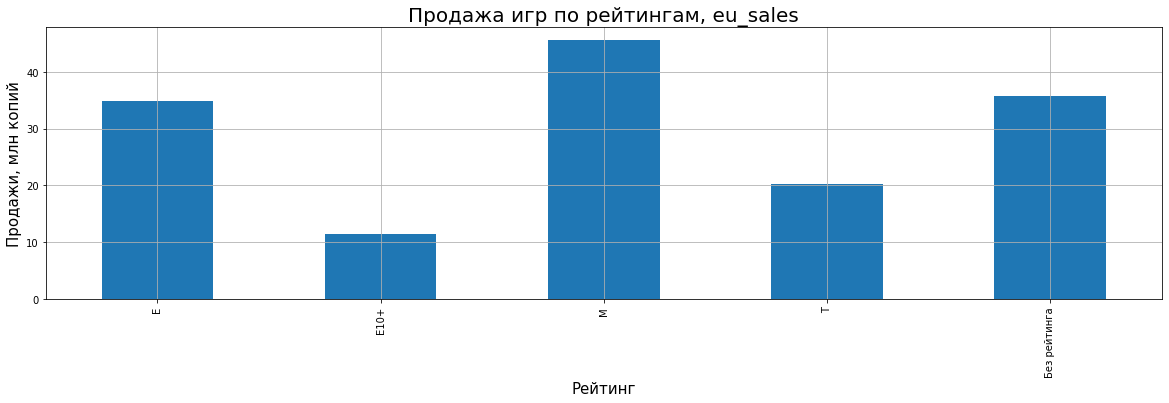

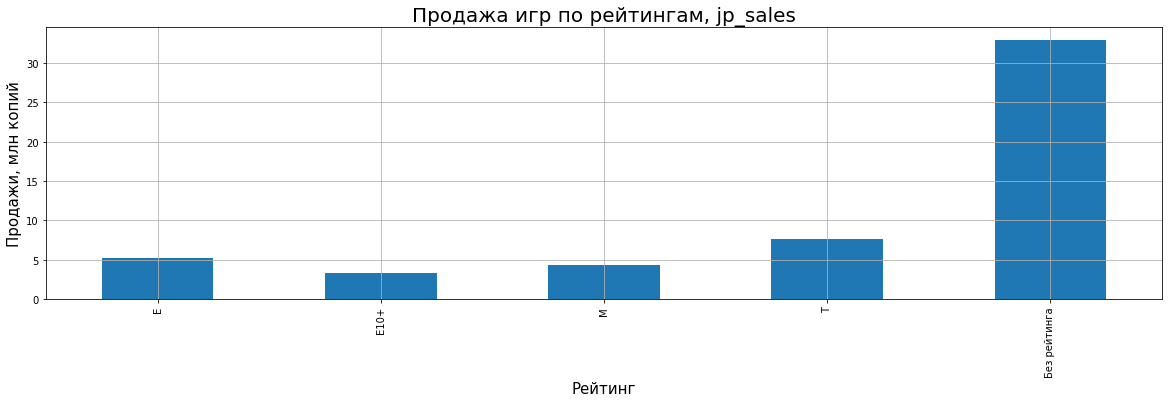

In [28]:
for x in ['na_sales', 'eu_sales', 'jp_sales']:
    df_actual.groupby('rating')[x].agg('sum').plot(kind='bar', figsize=(20,5), grid=True)
    plt.title(f'Продажа игр по рейтингам, {x}', fontsize=20)
    plt.xlabel('Рейтинг', fontsize=15)
    plt.ylabel('Продажи, млн копий', fontsize=15)
    plt.show()

В Северной Америке лидируют игры с рейтингом "М" ("для взрослых") - около 48 млн копий. Второе место занимают игры  "Без рейтинга" - 38 млн копий. В Европе схожая картина. Лидируют игры с рейтингом "М" - около 45 млн копий, затем "Е" и "Без рейтинга" - по 35 млн. копий. Самые низкие продажи у игр с рейтингом "E10+": в Северной Америке - 19 млн копий, в Европе - 11 млн копий.

В Японии картина совершенно другая. Лидируют продажи игр "Без рейтинга" - около 35 млн копий, продажи игр остальных рейтингов колеблются от 4 до 7 млн копий.

Игры в которых не указан рейтинг занимают большую долю в продажах. Для планирования выпуска игры необходимы уточнённые данные, которые бы раскрывали входящие туда игры.

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
    
Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC различаются.    

In [29]:
df_actual = df_actual.dropna(subset=['user_score'])
x_one = df_actual.query('platform == "XOne"')
pc = df_actual.query('platform == "PC"')
alpha = .05
results = st.ttest_ind(x_one['user_score'], pc['user_score'])
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.2778542084733835
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что вероятность получить такое или большее различие случайно почти 30%. Это слишком большая вероятность, чтобы делать вывод о значимом различии между оценками пользователей двух платформ.

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшенигры) и Sports (англ. «спортивные соревнования») разные


Нулевая гипотеза: средние пользовательские рейтинги жанров Action (англ. «действие», экшенигры) и Sports (англ. «спортивные соревнования») одинаковые.

Альтернативная гипотеза: средние пользовательские рейтинги жанров Action (англ. «действие», экшенигры) и Sports (англ. «спортивные соревнования») различаются.

In [30]:
action = df_actual.query('genre == "Action"')
sports = df_actual.query('genre == "Sports"')
alpha = .05
results = st.ttest_ind(action['user_score'], sports['user_score'])
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.0012846807938657e-13
Отвергаем нулевую гипотезу


Полученное значение p-value говорит о том, что вероятность получить такое или большее различие случайно крайне низка. Признаём верной альтернативную гипотезу.

## Общий вывод

В процессе выполнения работы было сделано следующее:
- ознакомились с полученными данными на предмет соответствия стоящей перед нами задачей,
- где это было возможно и целесообразно вставили пропущенные значения,
- посчитали и записали в отдельный столбец суммарные продажи во всех регионах,
- рассмотрели сколько игр выпускалось в разные годы,
- рассмотрели продажи по платформам,
- рассмотрели взаимосвязь отзывов пользователей и критиков с продажами,
- рассмотрели распределение игр по жанрам,
- составили портрет пользователя каждого региона,
- проверили гипотезы.

В ходе изучения данных установили:
- актуальный период, данные которого наиболее полно характеризуют тенденции настоящего и ближайшего будущего. В нашем случае это период 2015-2016 годов.
- средний срок "жизни" платформы длится около 11 лет; пика продаж новая платформа достигает к 4-5 году с момента появления,
- на основании рассмотрения продаж по платформам в актуальном периоде выделили две потенциально прибыльные платформы: PS4 и XOne,
- оценки пользователей никак не взаимосвязаны с продажами; есть некая связь оценок критиков, но она очень слаба, чтобы утверждать об этом уверенно,
- больше всего игр выпущено в жанре Action - 431 игра, меньше всего - Puzzle - 7 шт.,
- в среднем, наиболее продаваемые игры принадлежат к жанру Shooter - 0,38 млн копий, затем Sports - 0,12 млн копий, Role-Playing - 0,115 млн копий. Также выделяются и жанры с низкими продажами: Strategy - 0,05 млн копий, Adventure - 0.03 млн копий, Puzzle - 0,03 млн копий,
- портрет пользователя североамериканского региона: преобладающее использование игр на платформах PS4 - 64 млн копий и XOne - 50 млн копий; популярные жанры: Shooter, Action, Sports, Role-Playing; преобладают игры с рейтингом "M" - около 48 млн копий,
- портрет пользователя европейского региона: преобладающее использование игр на платформе PS4 - 83 млн копий; популярные жанры: Shooter, Action, Sports, Role-Playing; преобладают игры с рейтингом "M" - около 45 млн копий,
- портрет японского пользователя: популярны портативные консоли: 3DS на первом месте - 23 млн копий, PSV на третьем месте - 8 млн копий; популярные жанры: Action и Role-Playing; преобладают игры "Без рейтинга" - около 35 млн копий,
- в ходе проверки гипотез пришли к тому, что: средние пользовательские рейтинги платформ Xbox One и PC одинаковые, средние пользовательские рейтинги жанров Action (англ. «действие», экшенигры) и Sports (англ. «спортивные соревнования») различаются. 
